# Question 3: LSTM

Following question 1 (2), train a sequence to sequence (e.g., 4 timesteps to 4 timesteps) predictive model (e.g., LSTM)  in the reduced space, and decode predicted results in the full space. Evaluate your algorithm performance on the test dataset using different metrics (e.g., MSE, RMSE, SSIM…).

Reference: https://towardsdatascience.com/multivariate-time-series-forecasting-with-deep-learning-3e7b3e2d2bcf

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid

In [2]:
# Try to use GPU if available
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)

cuda:0


### Video sequence loading

In [3]:
# custom dataset to process videos
class VideoDataset(Dataset):
  def __init__(self, folder_path, sequence_length=4, video_length=16, transform=None):
    self.folder_path = folder_path
    self.sequence_length = sequence_length
    self.video_length = video_length
    self.transform = transform
    self.video_list = os.listdir(folder_path)
    self.sequences_per_video = self.video_length - 2 * self.sequence_length + 1

  def __len__(self):
    return len(self.video_list) * self.sequences_per_video

  def __getitem__(self, idx):
    video_idx = idx // self.sequences_per_video
    frame_idx = idx % self.sequences_per_video
    video_path = os.path.join(self.folder_path, self.video_list[video_idx])
    frames = self._load_video(video_path)
    input_seq, target_seq = self._get_sequence_pair(frames, frame_idx)
    return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(target_seq, dtype=torch.float32)

  def _load_video(self, video_path):
    frames = []
    cap = cv.VideoCapture(video_path)
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
      frame = frame / 255
      frames.append(frame.flatten())
    cap.release()

    frames = np.array(frames) # should be 16 x (128*128) i.e. 16 frames, each 128x128 frame flattened to 1d
    return frames

  def _get_sequence_pair(self, frames, frame_idx):
    input_seq = np.array(frames[frame_idx:frame_idx+self.sequence_length])
    target_seq = np.array(frames[frame_idx+self.sequence_length:frame_idx+2*self.sequence_length])
    return input_seq, target_seq

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 1
sequence_length = 4
folder_path = "./VIDEOS/training/"

video_dataset = VideoDataset(folder_path, sequence_length=sequence_length, transform=transform)
train_loader = DataLoader(video_dataset, batch_size=batch_size, shuffle=True)

### Visualise a few examples from the dataset

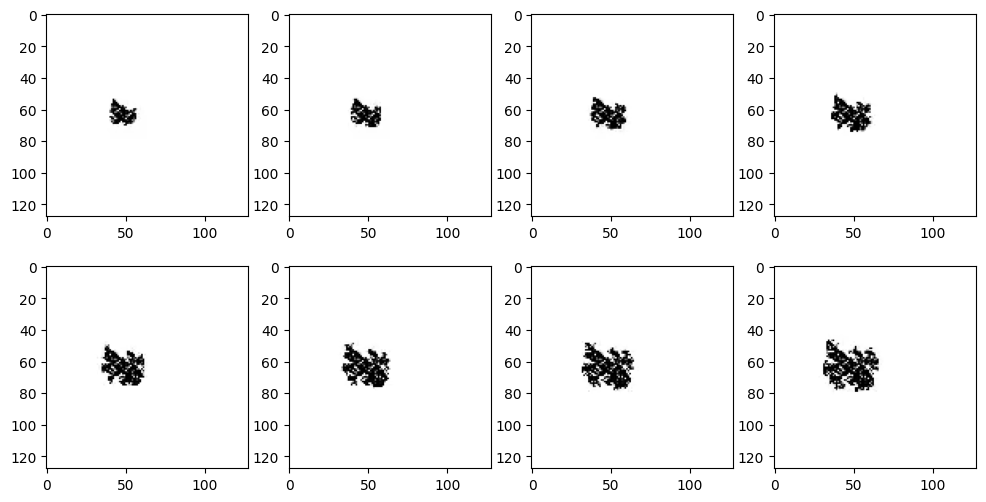

In [6]:
# Visualise a few examples from the train set to be sure it's working
def show(img):
    '''
    function to visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)).clip(0, 1), cmap='binary')

sample_input, sample_target = next(iter(train_loader))

sample_input, sample_target = sample_input.view(sequence_length, 128, 128), sample_target.view(sequence_length, 128, 128)

fig, ax = plt.subplots(2, 4, figsize=(12, 6))
for i in range(sequence_length):
    ax[0, i].imshow(sample_input[i], cmap='binary')
    ax[1, i].imshow(sample_target[i], cmap='binary')
plt.show()

### Seq2Seq model definition

In [7]:
# Define the seq2seq model
class Seq2SeqModel(nn.Module):
  def __init__(self, input_dim, latent_dim, num_layers=1):
    super(Seq2SeqModel, self).__init__()

    self.encoder = nn.LSTM(input_dim, latent_dim, num_layers, batch_first=True)
    self.decoder = nn.LSTM(latent_dim, latent_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(latent_dim, input_dim)

  def forward(self, input_seq):
    # Encoder
    _, (last_hidden, _) = self.encoder(input_seq)
    
    # reshape for batch
    encoded = last_hidden.repeat(len(input_seq), input_seq.size(1), 1)

    # Decoder
    decoder_output, _ = self.decoder(encoded)

    output = self.fc(decoder_output)
    
    return output

### Seq2Seq model training:

This LSTM autoencoder will be trained on the full image input (128x128) flattened to a 16,384-element vector. This is not good! Later, will experiment with reduced input dimensions.

In [11]:
# define function to train the model
def train(model, train_data, criterion, optimizer, epochs):
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    for input_seq, target_seq in train_data:
      input_seq, target_seq = input_seq.to(device, dtype=torch.float32), target_seq.to(device, dtype=torch.float32)
      optimizer.zero_grad()
      output_seq = model(input_seq)
      loss = criterion(output_seq, target_seq)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_data)}")

In [ ]:
# Set hyperparameters
input_dim = 128*128
latent_dim = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 50

In [ ]:
# Initialise model, loss function, and optimizer
model = Seq2SeqModel(input_dim, latent_dim, num_layers)
model = model.to(device=device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train the model
train(model, train_loader, criterion, optimizer, num_epochs)

### Evaluate on train set

To perform initial evaluations, I will load in the sequences of one video, stored in ./VIDEOS/small_test/, to visualise.

In [ ]:
folder_path = './VIDEOS/small_test/'
test_dataset = VideoDataset(folder_path, sequence_length=sequence_length, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(len(test_loader))

In [ ]:
def decode_predictions(predictions):
  return predictions.view(batch_size, sequence_length, 128, 128)  # Reshape to image dimensions

def visualise_one_test_video(model, test_loader):
  model.eval()
  for input_seq, target_seq in test_loader:
    with torch.no_grad():
      input_seq, target_seq = input_seq.to(device), target_seq.to(device)

      # Predict sequences in reduced space
      output_seq = model(input_seq)
      # Decode predicted results into full space
      decoded_predictions = decode_predictions(output_seq)
      decoded_targets = decode_predictions(target_seq)
      
      # Example: Convert the first sequence in the batch to an image (assuming grayscale)
      
      fig, ax = plt.subplots(2, 4, figsize=(12, 6))

      for i in range(sequence_length):
        example_prediction = decoded_predictions[0, i].cpu().numpy()  # Extract first prediction from batch
        example_prediction = np.uint8(example_prediction * 255)  # Convert to 8-bit grayscale

        example_target = decoded_targets[0, i].cpu().numpy()
        example_target = np.uint8(example_target * 255)

        ax[0, i].imshow(example_prediction, cmap='binary')
        ax[1, i].imshow(example_target, cmap='binary')

      plt.show()

visualise_one_test_video(model, test_loader)

### Train model on reduced-dimension inputs

Clearly, passing in the flattened full image is not good. Instead, I will pass in the input images to the CAE, perform the LSTM encode/decode process using the encoded result of the CAE, and then decode the output of the LSTM decode process using the CAE decoder, and compute reconstruction accuracy that way.

In [12]:
# Define the CAE_LSTM model
class CAE_LSTM(nn.Module):
  def __init__(self, input_x, input_y, cae_latent_dim, lstm_latent_dim, num_layers=1):
    super(CAE_LSTM, self).__init__()
    self.input_x, self.input_y = input_x, input_y
    self.cae_latent_dim = cae_latent_dim

    # CAE encoder
    self.cae_encoder = nn.Sequential(
      nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(8),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(16),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(32, self.cae_latent_dim, kernel_size=3, stride=1, padding=1),
      nn.ReLU(0.2),
      nn.BatchNorm2d(self.cae_latent_dim),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # CAE decoder
    self.cae_decoder = nn.Sequential(
      nn.ConvTranspose2d(self.cae_latent_dim, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.ReLU(0.2),
      nn.BatchNorm2d(32),

      nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.ReLU(0.2),
      nn.BatchNorm2d(16),
      
      nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.ReLU(0.2),
      nn.BatchNorm2d(8),
      
      nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.Sigmoid()
    )

    # LSTM encoder
    self.lstm_encoder = nn.LSTM(
      (self.input_x // 16) * (self.input_y // 16) * self.cae_latent_dim,
      lstm_latent_dim,
      num_layers,
      batch_first=True
    )

    # LSTM decoder
    self.lstm_decoder = nn.LSTM(
      lstm_latent_dim,
      lstm_latent_dim,
      num_layers,
      batch_first=True
    )

    # Fully-connected layer
    self.fc = nn.Linear(
      lstm_latent_dim,
      (self.input_x // 16) * (self.input_y // 16) * self.cae_latent_dim
    )

  def forward(self, x):
    # obtain the encoded form of the input sequence
    encoded_sequence = []
    
    # for each frame in the sequence:
    for i in range(sequence_length):
      # resize the frame to shape [batch_size, 1, image width, image height]
      # i.e get each frame
      frame = x[:, i, :].view(len(x), 1, self.input_x, self.input_y)

      # get the encoded form of this frame from the encoder part of the CAE
      encoded_frame = self.cae_encoder(frame)

      # store the encoded form of this frame
      encoded_sequence.append(encoded_frame)
    
    # concatenate all the encoded frames into a tensor of shape [batch_size, sequence_length, output shape of CAE encoder]
    encoded_sequence = torch.stack(encoded_sequence, dim=1)

    # flatten the encoded form of each frame, i.e. give the encoded sequence shape [batch_size, sequence_length, flattened size of encoder output]
    encoded_sequence = encoded_sequence.view(batch_size, sequence_length, -1)
    
    # run the encoded input through the LSTM network
    _, (last_hidden, _) = self.lstm_encoder(encoded_sequence)

    # repeat the hidden state of the last lstm module in the encoder part of the LSTM autoencoder to fill the batch size and sequence length
    encoded = last_hidden.repeat(1, sequence_length, 1)

    # get the predictions from the LSTM
    decoder_output, _ = self.lstm_decoder(encoded)

    # pass the predictions through a fully connected layer
    output = self.fc(decoder_output)

    # resize for decoder
    output = output.view(
      batch_size,
      sequence_length,
      self.cae_latent_dim,
      self.input_x // 16,
      self.input_y // 16
    )

    # get the decoded form of each frame in the sequence
    decoded_sequence = []

    # for each frame
    for i in range(sequence_length):
      # get the encoded frame from the output of the LSTM decoder
      code = output[:, i, :, :, :]

      # pass this through the CAE decoder to decode
      decoded_frame = self.cae_decoder(code)

      # store it
      decoded_sequence.append(decoded_frame)
    
    # put all the decoded frames together for the sequence
    decoded_sequence = torch.stack(decoded_sequence, dim=1)

    # resize the decoded sequence to flatten the images
    output = decoded_sequence.view(batch_size, sequence_length, -1)

    # obtain the decoded images
    return output

In [13]:
# Set hyperparameters
input_dim = 128
num_layers = 1
learning_rate = 0.001

cae_latent_dim = 128
lstm_latent_dim = 512
num_epochs = 50

# Initialise model, loss function, and optimizer
model = CAE_LSTM(input_dim, input_dim, cae_latent_dim, lstm_latent_dim, num_layers)
model = model.to(device=device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
# Train the model
train(model, train_loader, criterion, optimizer, num_epochs)

Epoch 1, Loss: 0.3082261719637447
Epoch 2, Loss: 0.06663903006249004
Epoch 3, Loss: 0.04467718085636281
Epoch 4, Loss: 0.03723318490406705
Epoch 5, Loss: 0.03244684217756407
Epoch 6, Loss: 0.029687441183098903
Epoch 7, Loss: 0.028308214298643483
Epoch 8, Loss: 0.02674804287380539
Epoch 9, Loss: 0.027002896997793062
Epoch 10, Loss: 0.02455808107285217
Epoch 11, Loss: 0.024104458119189882
Epoch 12, Loss: 0.02299083260133759
Epoch 13, Loss: 0.02266750900550202
Epoch 14, Loss: 0.02166550933600067
Epoch 15, Loss: 0.021727168628583766
Epoch 16, Loss: 0.021419744027338716
Epoch 17, Loss: 0.020755614428101882
Epoch 18, Loss: 0.020668654441396938
Epoch 19, Loss: 0.020211074657709105
Epoch 20, Loss: 0.01969598717696499
Epoch 21, Loss: 0.019428753629957402
Epoch 22, Loss: 0.01923143783036115
Epoch 23, Loss: 0.019437885460340313
Epoch 24, Loss: 0.01924464226750489
Epoch 25, Loss: 0.01895381151924893
Epoch 26, Loss: 0.01927805766916006
Epoch 27, Loss: 0.01893275467955391
Epoch 28, Loss: 0.018183311

In [15]:
folder_path = './VIDEOS/small_test/'
test_dataset = VideoDataset(folder_path, sequence_length=sequence_length, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(len(test_loader))

9


In [18]:
def decode_predictions(predictions):
  return predictions.view(batch_size, sequence_length, 128, 128)  # Reshape to image dimensions

def visualise_one_test_video(model, test_loader):
  model.eval()
  for input_seq, target_seq in test_loader:
    with torch.no_grad():
      input_seq, target_seq = input_seq.to(device), target_seq.to(device)

      # Predict sequences in reduced space
      output_seq = model(input_seq)

      # Decode predicted results into full space
      decoded_predictions = decode_predictions(output_seq)
      decoded_targets = decode_predictions(target_seq)
      print(decoded_targets.shape)
      
      # Example: Convert the first sequence in the batch to an image (assuming grayscale)
      
      fig, ax = plt.subplots(2, 4, figsize=(12, 6))

      for i in range(sequence_length):
        example_prediction = decoded_predictions[0, i].cpu().numpy()  # Extract first prediction from batch
        example_prediction = np.uint8(example_prediction * 255)  # Convert to 8-bit grayscale

        example_target = decoded_targets[0, i].cpu().numpy()
        example_target = np.uint8(example_target * 255)

        ax[0, i].imshow(example_prediction, cmap='binary')
        ax[1, i].imshow(example_target, cmap='binary')

      plt.show()

torch.Size([1, 4, 128, 128])


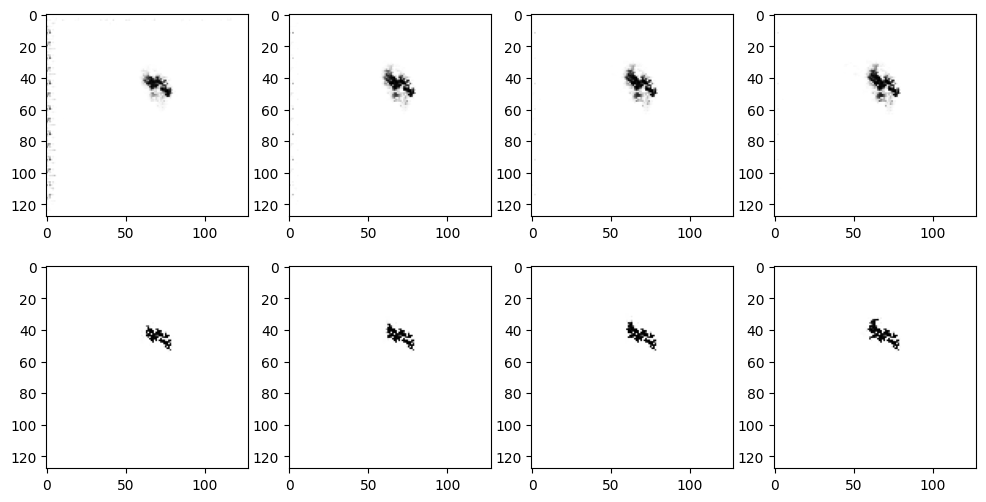

torch.Size([1, 4, 128, 128])


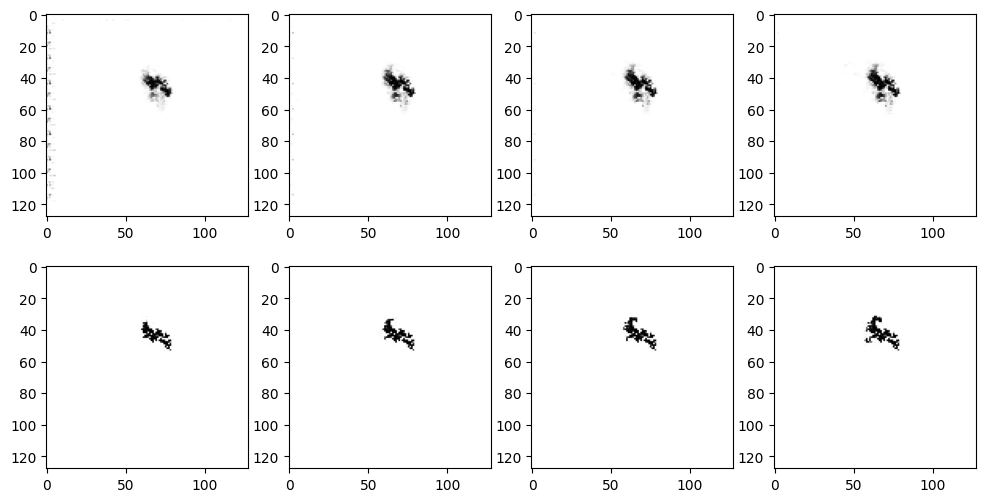

torch.Size([1, 4, 128, 128])


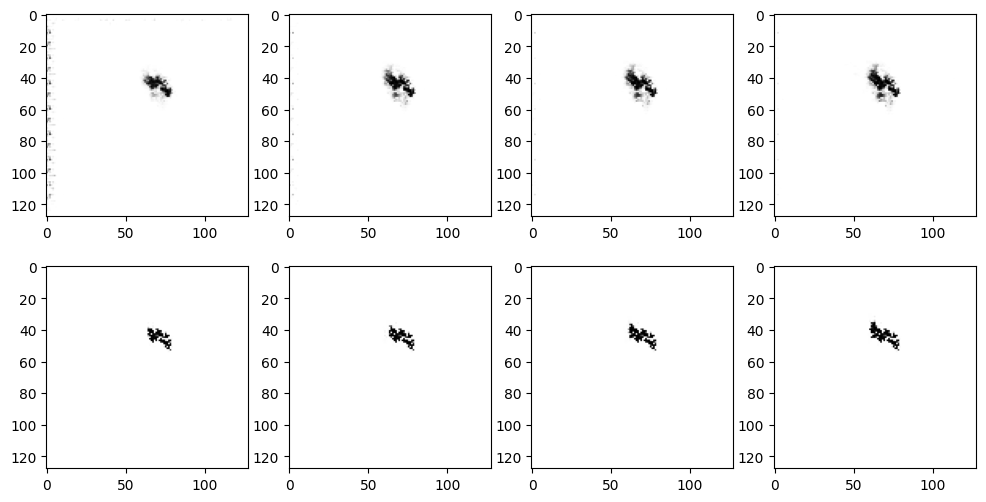

torch.Size([1, 4, 128, 128])


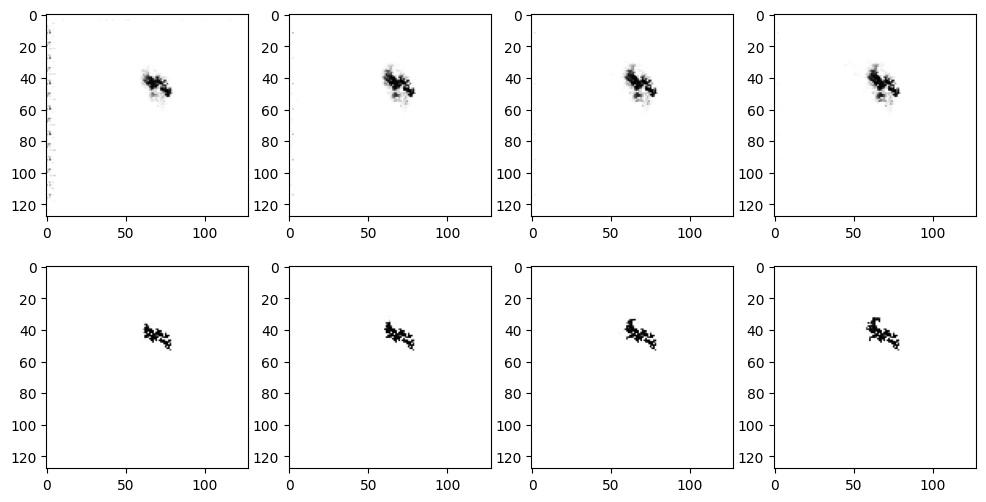

torch.Size([1, 4, 128, 128])


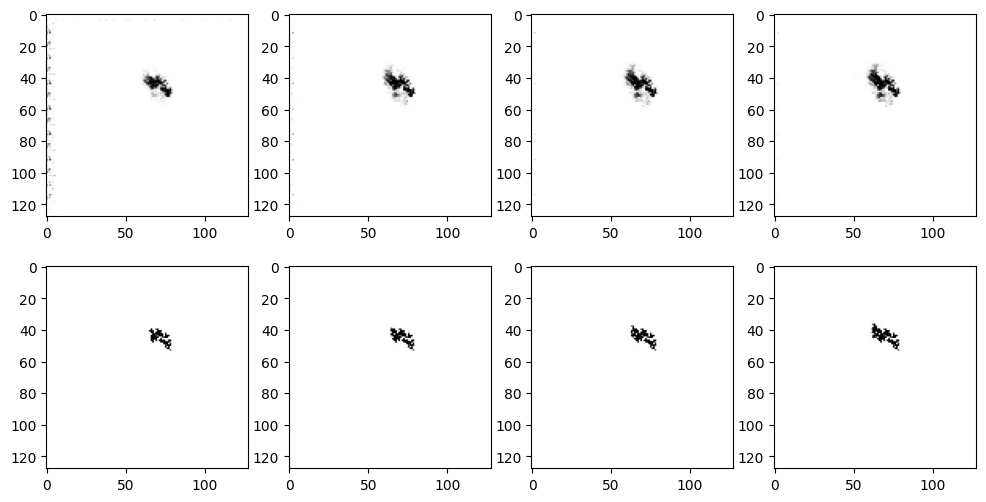

torch.Size([1, 4, 128, 128])


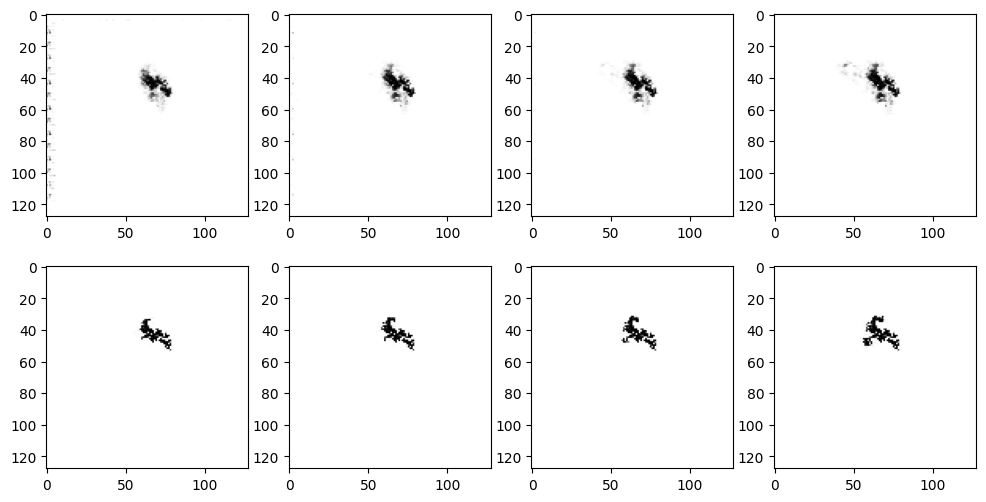

torch.Size([1, 4, 128, 128])


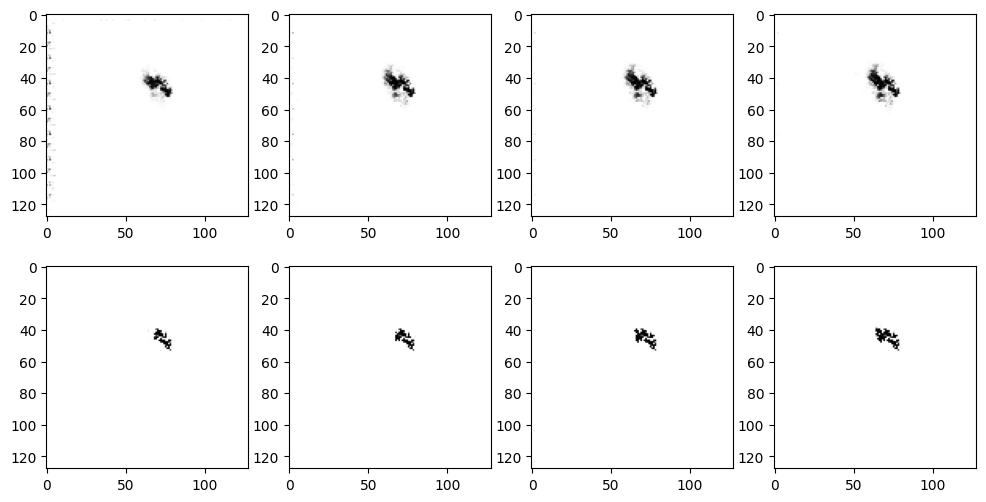

torch.Size([1, 4, 128, 128])


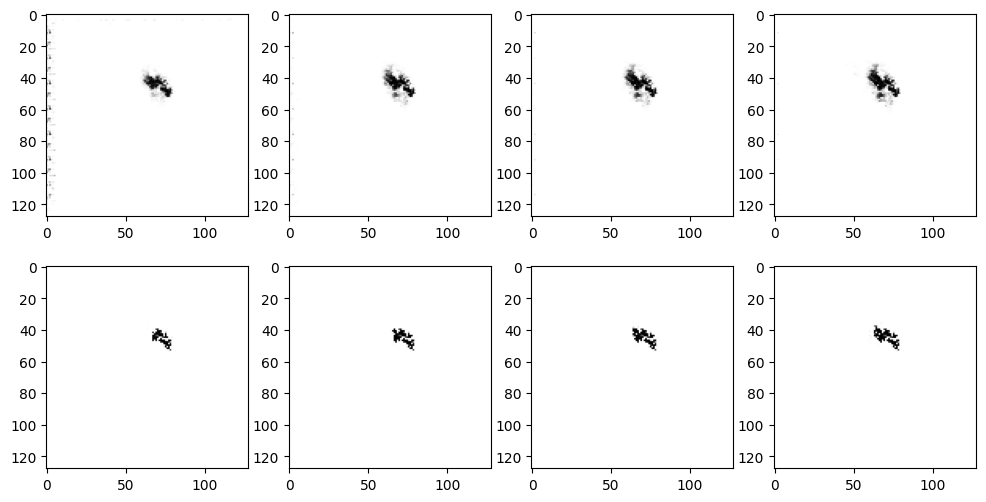

torch.Size([1, 4, 128, 128])


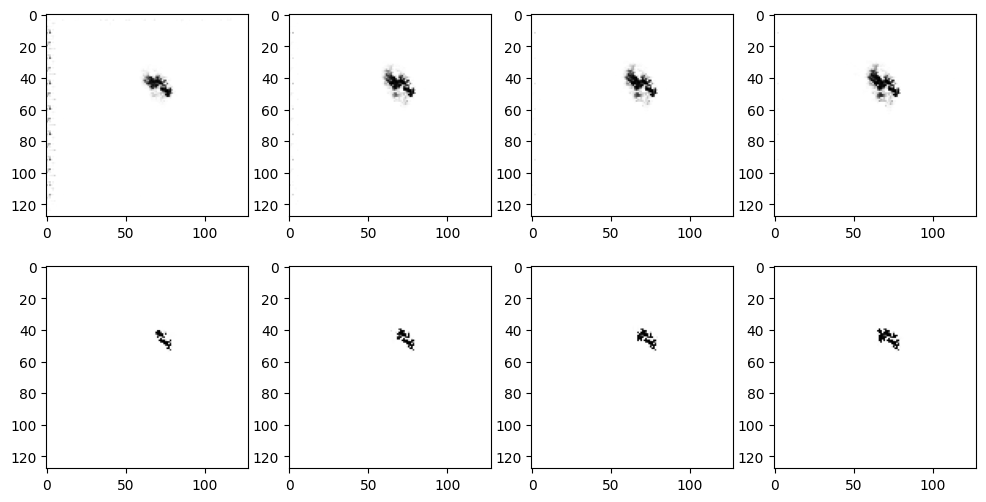

In [19]:
visualise_one_test_video(model, test_loader)